In [1]:
# load your Python Libraries here
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import linregress
from scipy.stats import pearsonr

***
# Add functions here 
***

In [2]:
def read_gridded_data(filename, report=True):
    """ function to read regular gridded data files and return a Python dictionary.
    inputs: filename -> name of file to be read
            report   -> boolean flag, if true then a table listing the file contents is printed to screen

    outputs: data    -> a python dictionary containing the file contents
    """
    # open the file and map the contents to a netCDF object. Use a test to capture
    # any issues with the data file
    try:
        nc = netCDF4.Dataset(filename,"r")
    except IOError:
        raise
    # if report is set to true then prind global attributes
    if report == True:
        print(f"Global Attributes For File: {filename}") # when witing strings, starting them with an 'f' allows you to insert other variables using {}.
        print("----------------------------------------------------------------------------------------------------")
        print(nc)
    # Define a dictionary to hold the contents
    data = {} 
    # loop over the file contents and write
    if report == True:
        # what variables are in this file?
        # printing Aligned Header 
        print("-------------------------------------------------------------------")        
        print(f"{'Variable Name' : <14} |{'Long Name':<32} |{'tdim, ydim, xdim':>17}") 
        print("-------------------------------------------------------------------")
    else:
        pass # we add a pass so we can close this if statement with an else

    for varname in nc.variables.keys():
        if report == True:
            print(f"{varname:<14} |{nc[varname].long_name:<32} |{', '.join([str(d) for d in nc[varname].shape]):>17}")
        else:
            pass
        # write the variable to the dictionary
        data[varname] = nc[varname][:] #  the [:] at the end indexes all the data
    
    # finally close the file
    nc.close()

    # return the filled data dictionary
    return data

In [3]:
def simple_moving_average(yvals, width):
    """ compute the moving average of a time series with a user defined sliding window.
    inputs: yvals -> time series on regular time steps
            width -> width of sliding window (n time steps)
    output: sommothed time series
    """
    return np.convolve(yvals, np.ones(width), 'same')/width

In [4]:
########################################################################
#                                                                      #
########################################################################
def read_csv(filename):
    """ read in the csv files we previously made of UTH anomaly time series.
    inputs: filename -> full path to file containing our data

    ouputs: results -> python dictionary containing our anomaly time series.
    """
    results = {}
    data = np.loadtxt(filename, skiprows=1, delimiter=",",dtype='<f4')
    header = np.genfromtxt(filename, delimiter=',', dtype=str, max_rows=1)
    for ii, varname in enumerate(header):
        results[varname] = data[:,ii]
    return results


In [115]:
def calculate_probDensFunc(yvals, ymin, ymax,nbins=100):
    """ calculate a PDF from the array yvals using scipy.stats norm module
    inputs: yvals -> 1d array of values to be used in PDF calculation
            ymin  -> minimum value for range of yvals PDF is calculated
            ymax  -> maximum value for range of yvals PDF is calculated
            nbins -> number of bins for which PDF is calculated between ymin  and ymax
            
    outputs: xvals -> array of values over which the PDF was calculated (defined by ymin, ymax,nbins)
             PDF   -> array containing PDF values
    """
    # define xvals
    xvals = np.linspace(ymin,ymax,nbins)

    # calculate mean and standard deviation of yvals
    mu = np.mean(yvals)
    std = np.std(yvals)

    # define an empty array to hold PDF values. Here we use the size method to tell the code how many elements 
    # are in this new array and fill each entry with a default value NaN (Not a Number)
    PDF = np.full(xvals.size, np.nan)

    # loop over each value in x and calculate the corresponding PDF value. Because xvals is an array merans in 
    # Python it is iterable (i.e. we can loop over the contents) and by wrapping it in the enumerate function
    # we also get the index of the value (e.g. the firts value in xvals could be -2, therefore x=-2 and ii=0).
    for ii, x in enumerate(xvals):
        PDF[ii] = norm.pdf(x, loc=mu, scale=std)

    # return the results
    return PDF, xvals

In [47]:
def plot_studyVar_vs_Ts(ts_anom, sv_anom, sv_name, sv_units, region1, region2):
    # regress the two time series against each other
    slope, intercept, r, p, se = linregress(ts_anom, sv_anom)
    # convert pearson coefficient to a string 
    Rs = f"{r:0.2f}"
    if p < 0.01:
        Rs+="*"

    vmin =-1.5
    vmax = 2.5
    # plot scatter
    plt.plot(ts_anom, sv_anom, 'o',color="#2E75B6",mec='#1F3649')
    # plot fit
    xg = np.linspace(vmin,vmax,50)
    yg = intercept+slope*xg
    plt.plot(xg, yg,'--',color="#C55A11",lw=2,label=f"{slope:0.2f}"+r"$\pm$"+f"{se:0.2f} {sv_units}/K")
    plt.ylabel(f"{region1} "+r"$\Delta$"+f"{sv_name} ({sv_units})")
    plt.xlabel(f'{region2} '+r"$\Delta$T$_{s}$ (K)")
    plt.title(f'R={Rs}')
    #plt.ylim(-2.5,1.5)
    plt.xlim(vmin,vmax)
    plt.legend()
    plt.grid(True)

In [147]:
def plot_pdfs(xvals, pre_pdf_glb, aft_pdf_glb, pre_pdf_reg, aft_pdf_reg, surface, region, vname, units):
    """ plot pdf global and regional"""
    plt.plot(xvals, pre_pdf_glb, "-.", lw=2,color='#1F3649',alpha=0.8,label=f'{surface} (1979-2000)')
    plt.plot(xvals, pre_pdf_reg, "-.",lw=2,color="#2E75B6",alpha=0.8,label=f'{region} (1979-2020)')
    
    plt.plot(xvals, aft_pdf_glb, lw=2, color='#1F3649',label=f'{surface} (2001-2024)')
    plt.plot(xvals, aft_pdf_reg, lw=2, color="#2E75B6",label=f'{region} (2001-2024)')
    
    maxval = round(1.1*np.max([pre_pdf_glb.max(), aft_pdf_glb.max(), pre_pdf_reg.max(), aft_pdf_reg.max()]),1)
    plt.xlim(xvals.min(),xvals.max())
    plt.ylim(0,maxval)
    plt.xlabel(f"{vname} ({units})")
    plt.ylabel("PDF",fontsize=12)
    plt.legend(loc='best',fontsize=8)

***
# Load in data
### **NOTE**: if you put this in the PA260X_CourseWorkMaterials directory then you need to remove ../A260X_CourseWorkMaterials/ from the begining of the path
***

In [191]:
# Land seam mask, needed by all
lsm_filename = "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Land_sea_mask_2.5_x_2.5_1950_2020.nc"

# skin temperature data, needed by all
Ts_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Skin_temperature_2.5_x_2.5_1950_1989.nc",
              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Skin_temperature_2.5_x_2.5_1990_2020.nc"]

#================================================================
# SPECIFIC VARIABLE DATA, ONLY NEED ONE - UNCOMMENT AS APPROPIATE
# sv_filelist = study variable filelist
#=================================================================
# Monthly Mean Total Column Water Vapour (TCWV)
#sv_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Total_column_water_2.5_x_2.5_1950_1989.nc",
#              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Total_column_water_2.5_x_2.5_1990_2020.nc"]

# Monthly mean precipiation rate (PR_RATE)
#sv_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_precip_rate_2.5_x_2.5_1950_1989.nc",
#              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_precip_rate_2.5_x_2.5_1990_2020.nc"]

# Monthly Mean Fresh Water Flux, or Evaporation-Precipitaion (FWF or E-P)
sv_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_EminusP_2.5_x_2.5_1950_1989.nc",
              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_EminusP_2.5_x_2.5_1990_2020.nc"]

# Monthly Mean Soil Moisture
#sv_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_soil_moisture_2.5_x_2.5_1950_1989.nc",
#              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_soil_moisture_2.5_x_2.5_1990_2020.nc"]

# monthly mean weighted stratospheric temperature (50-10 hPa)
#sv_filelist= ["../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Weighted_average_stratospheric_temperature_2.5_x_2.5_1950_1989.nc",
#              "../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_Weighted_average_stratospheric_temperature_2.5_x_2.5_1990_2020.nc"]



In [192]:
# first load the LSM
lsm_data = read_gridded_data(lsm_filename, report=False)

In [193]:
# next load in the skin temperature data
# let now loop over each file, read the contents, and stack the results
for ii, fname in enumerate(sorted(Ts_filelist)):
    # because we can iterate overlists in Python, we canuse the enumerate() 
    # method to give us the positional index at the same time (e.g. 0,1,2,3..).
    # We have also use the sorted() method to force the list into chronological
    # order - which happens because the filenames have been formatted with the 
    # date in YYYYMMDD at the end of the filename.  
    
    if ii == 0:
        # for the first file we assign it to the dictionary avhrr_data with Ch1 and Ch2 variables 
        # dimensions of (1,900,1800)
        ts_data = read_gridded_data(fname, report=False)
    else:
        # for every other file we stack the contents of Ch1 and Ch2 on top such that the dimensions
        # avhrr_data[Ch1] and avhrr_data[Ch2] are (2,900,1800) when the second file is read in, 
        # (3,900,1800) when the third is read in and so on until the final dimensions are (10,900,1800)
        
        tmp = read_gridded_data(fname, report=False) # hold output in a temporary dictionarry
        ts_data['skt'] = np.vstack([ts_data['skt'], tmp['skt']])
        ts_data['time'] = np.append(ts_data['time'], tmp['time'])

        # delete the temporary dictionary
        del tmp

In [194]:
# Finally read in study variable
sv_data = read_gridded_data(sv_filelist[0])

Global Attributes For File: ../PA260X_CourseWorkMaterials/data/pa260x_ecmwf_EminusP_2.5_x_2.5_1950_1989.nc
----------------------------------------------------------------------------------------------------
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Monthly mean freshwater flux from ERA5 Reanalysis
    Conventions: CF-1.5
    Metadata_Conventions: Unidata Dataset Discovery v2.0
    id: 
    product_version: v2.0
    institution: UoL
    creator_url: http://www.le.ac.uk
    creator_email: t.trent@le.ac.uk
    time_coverage_start: 194001010000
    time_coverage_stop:  202412312359
    cdm_data_type: grid
    geospatial_lat_units: degrees_north
    geospatial_lat_resolution: 2.5
    geospatial_lat_min: -90
    geospatial_lat_max: 90
    geospatial_lon_units: degrees_east
    geospatial_lon_resolution: 2.5
    geospatial_lon_min: -180
    geospatial_lon_max: 180
    date_created: 2025-03-07 00:46:17.871552
    filename: pa260x_ecmwf_EminusP_2.5

### Depending on your study varaible you will need a different variable name to index the data inside the netCDF file
 
 | Variable Name  | Long Name                                  | tdim | ydim | xdim |
 | -------------- | ------------------------------------------ | ---- | ---- | -----|
 | longitude      | longitude                                  |      |      |  144 |            
 | latitude       | latitude                                   |      |   72 |      |           
 | time           | time                                       |  480 |      |      |            
 | tcw            | Total column water                         |  480 |   72 |  144 |
 | pr             | precipiation rate                          |  480 |   72 |  144 |
 | fwf            | freshwater flux                            |  480 |   72 |  144 |
 | swvl           | Total volumetric soil water layers 1-4     |  480 |   72 |  144 |
 | t              | Weighted average stratospheric temperature |  480 |   72 |  144 |

In [9]:
%%html
<!-- IGNORE THIS CODE IT JUST SHIFT THE TABLE TO THE LEFTHAND EDGE OF THE PAGE -->
<style> 
table {float:left}
</style> 

In [195]:
# next load in the study variable data
# let now loop over each file, read the contents, and stack the results

# uncomment the correct variable name 
#svname = 'tcw'
#svname = 'pr'
svname = 'fwf'
#svname = 'swvl'           


for ii, fname in enumerate(sorted(sv_filelist)):
    # because we can iterate overlists in Python, we canuse the enumerate() 
    # method to give us the positional index at the same time (e.g. 0,1,2,3..).
    # We have also use the sorted() method to force the list into chronological
    # order - which happens because the filenames have been formatted with the 
    # date in YYYYMMDD at the end of the filename.  
    
    if ii == 0:
        # for the first file we assign it to the dictionary avhrr_data with Ch1 and Ch2 variables 
        # dimensions of (1,900,1800)
        sv_data = read_gridded_data(fname, report=False)
    else:
        # for every other file we stack the contents of Ch1 and Ch2 on top such that the dimensions
        # avhrr_data[Ch1] and avhrr_data[Ch2] are (2,900,1800) when the second file is read in, 
        # (3,900,1800) when the third is read in and so on until the final dimensions are (10,900,1800)
        
        tmp = read_gridded_data(fname, report=False) # hold output in a temporary dictionarry
        sv_data[svname] = np.vstack([sv_data[svname], tmp[svname]])
        sv_data['time'] = np.append(sv_data['time'], tmp['time'])

        # delete the temporary dictionary
        del tmp

***
# Global timesries processing
### Note: you wil see there are 3 choices global land, global ocean, global land+ocean. Uncomment the correct one for you
***

In [196]:
# NOTE UNCOMMENT THE APPROPIATE GLOBAL MASK, DEFAULT IS GLOBAL LAND
#===================================================================
# global land + ocean
#glb_mkr = np.where(lsm_data['lsm'] >=0 )
#surface ='Global'

# global land
glb_mkr = np.where(lsm_data['lsm'] > 0.3 )
surface ='Global Land'

# global ocean
#glb_mkr = np.where(lsm_data['lsm'] < 0.3 )
#surface ='Global Ocean'

### lets do skin temeprature first 

In [197]:
# CALCULATE GLOBAL SURFACE TEMPERATURES FOR IDENTIFIED SURFACE
#==============================================================

# first remove the surface data we do not want. Create a new array and 
# write only valid data to it
Ts_glb = np.full(ts_data['skt'].shape, np.nan)
for tt in range(Ts_glb.shape[0]):
    Ts_glb[tt,:,:][glb_mkr] = ts_data['skt'][tt,:,:][glb_mkr]

C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_14992\1737004869.py:4: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], np.nanmean(Ts_glb,axis=0), vmin=250, vmax=310,cmap=plt.get_cmap('coolwarm', 12))


Text(0.5, 1.0, 'Average Global Land Skin Temperature')

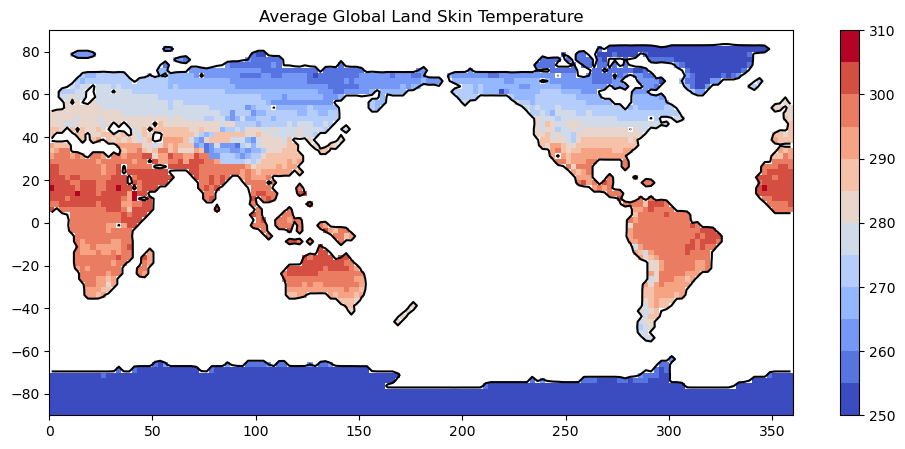

In [198]:
# QUICK TEST PLOT
#================
plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], np.nanmean(Ts_glb,axis=0), vmin=250, vmax=310,cmap=plt.get_cmap('coolwarm', 12))
plt.colorbar()
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title(f"Average {surface} Skin Temperature")

In [199]:
# lets create weights for calculating the weighted global mean
#=============================================================
x2d, y2d = np.meshgrid(ts_data['longitude'], ts_data['latitude'])
wgts = np.cos(np.radians(y2d))


In [200]:
# calculate weighted mean time series of skin temperature and study variable
tdim, ydim, xdim = Ts_glb.shape
Ts_timeseries = np.full(tdim, np.nan)
for tt in range(tdim):
    # create a varialbe to scale the weights eithe by 1 or NaN. This is a simple way to
    # ensure the sum of the weights is masked according to the surface type
    scale = np.full((ydim, xdim),np.nan)
    scale[glb_mkr] = 1.0
    Ts_timeseries[tt] = np.nansum(Ts_glb[tt,:,:]*wgts)/np.nansum(scale*wgts)

In [201]:
# calculate anomalies
# NOTE; we need to establish a common baseline period for the analysis. We will use 1960-1990
ref_period = np.where((ts_data['time'] >= 1960)&(ts_data['time'] < 1990))
Ts_anom = np.full(tdim, np.nan)
for mth in range(12):
    Ts_anom[mth::12] = Ts_timeseries[mth::12] - np.mean(Ts_timeseries[ref_period][mth::12])

In [202]:
# smooth the time series with running average of 12 months
smth_win = 12
Ts_anom_smoothed = simple_moving_average(Ts_anom, smth_win)
 

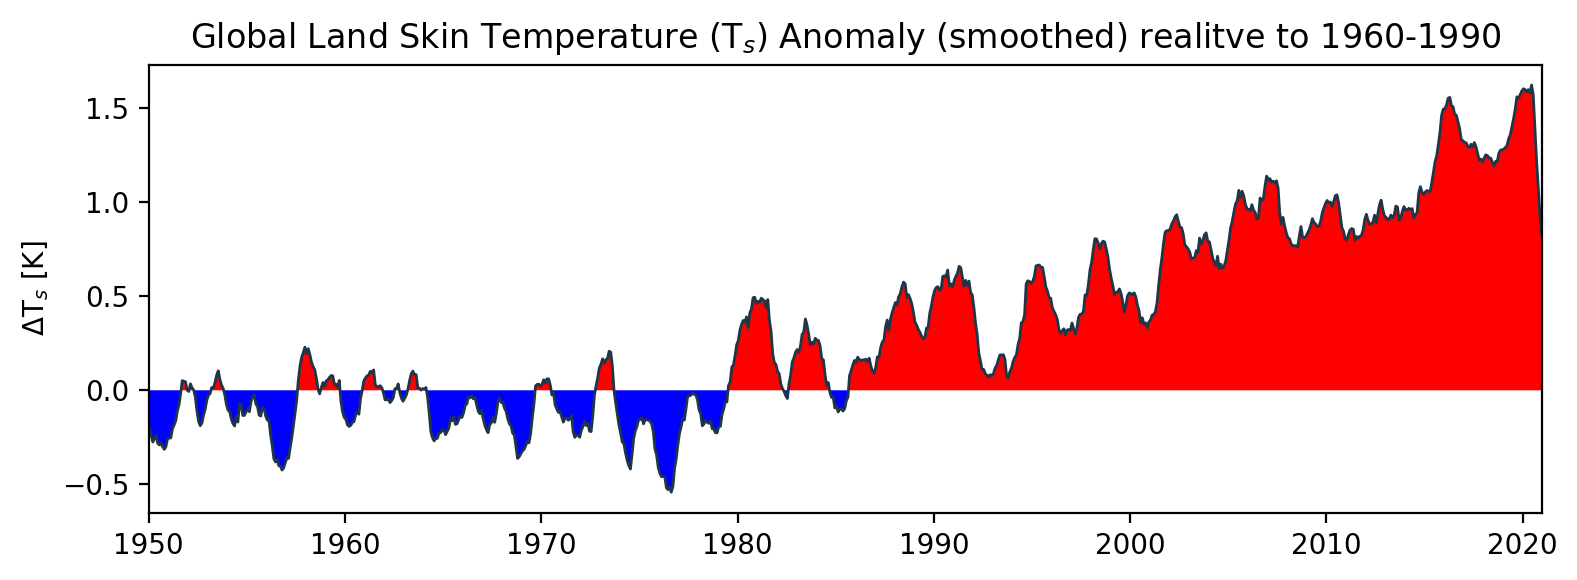

In [203]:
# QUICK TEST PLOT - smoothed anomaly timeseries 
#==============================================
plt.figure(figsize=(8,3),dpi=200)
plt.fill_between(ts_data['time'], Ts_anom_smoothed , where=Ts_anom_smoothed >= 0, facecolor="red",interpolate=True)
plt.fill_between(ts_data['time'], Ts_anom_smoothed , where=Ts_anom_smoothed  < 0, facecolor="blue",interpolate=True)
plt.plot(ts_data['time'], Ts_anom_smoothed ,color='#1F3649',lw=1)
plt.xlim(int(ts_data['time'][0]), int(ts_data['time'][-1])+1)
plt.ylabel(r"$\Delta$T$_{s}$ [K]")
plt.title(f"{surface} "+r'Skin Temperature (T$_{s}$) Anomaly (smoothed) realitve to 1960-1990')
plt.tight_layout()

### lets do study variable next 

In [204]:
# CALCULATE GLOBAL STUDY VARIABLE FOR IDENTIFIED SURFACE
#==============================================================

# first remove the surface data we do not want. Create a new array and 
# write only valid data to it
sv_glb = np.full(sv_data[svname].shape, np.nan)
for tt in range(sv_glb.shape[0]):
    sv_glb[tt,:,:][glb_mkr] = sv_data[svname][tt,:,:][glb_mkr]

C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_14992\596498251.py:37: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], np.nanmean(sv_glb,axis=0), vmin=vmin, vmax=vmax,cmap=plt.get_cmap('Spectral_r', 12))


Text(0.5, 1.0, 'Average freshwater flux (Global Land) mm/day')

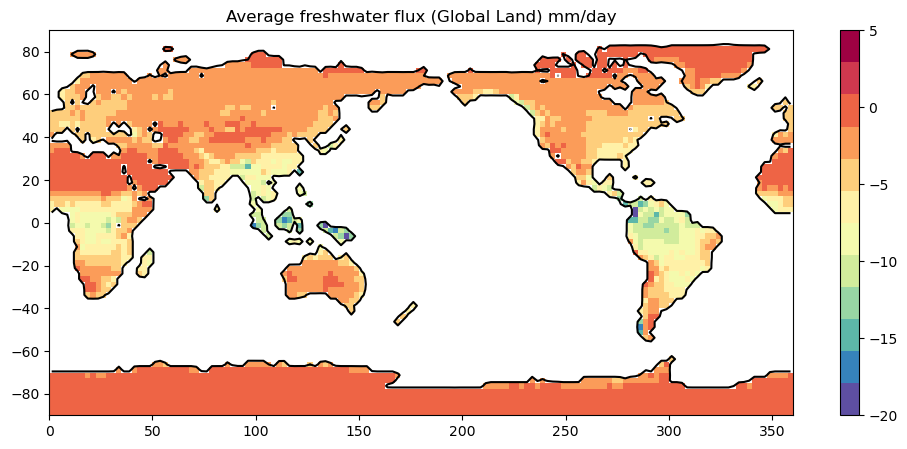

In [209]:
# QUICK TEST PLOT
#================

if svname == "tcw":
    longname = "Total Column Water Vapour"
    units = r"kg/m$^{2}$" # or this can be mm
    shortname = "TCWV"
    vmin=0
    vmax= 70
elif svname == "pr":
    longname = "Precipiation Rate"
    units = "mm/day"
    shortname = "PR"
    vmin=0
    vmax= 70
elif svname == "fwf":
    longname = "freshwater flux" 
    units = "mm/day"
    shortname = "FWF"
    vmin= -20
    vmax= 5
elif svname == "swvl":
    longname = "Total volumetric soil water layers 1-4" 
    units = "mm"
    shortname = "SM"
    vmin= -70
    vmax= 70
elif svname == "t":
    longname = "Weighted average stratospheric temperature"
    units = "K"
    shortname = r"T$_{Strat}$"
    vmin= 162
    vmax= 272


plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], np.nanmean(sv_glb,axis=0), vmin=vmin, vmax=vmax,cmap=plt.get_cmap('Spectral_r', 12))
plt.colorbar()
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title(f"Average {longname} ({surface}) {units}")

In [210]:
# calculate weighted mean time series of skin temperature and study variable
sv_timeseries = np.full(tdim, np.nan)
for tt in range(tdim):
    # create a varialbe to scale the weights eithe by 1 or NaN. This is a simple way to
    # ensure the sum of the weights is masked according to the surface type
    scale = np.full((ydim, xdim),np.nan)
    scale[glb_mkr] = 1.0
    sv_timeseries[tt] = np.nansum(sv_glb[tt,:,:]*wgts)/np.nansum(scale*wgts)

In [211]:
# calculate anomalies
# NOTE; we need to establish a common baseline period for the analysis. We will use 1960-1990
ref_period = np.where((ts_data['time'] >= 1960)&(ts_data['time'] < 1990))
sv_anom = np.full(tdim, np.nan)
for mth in range(12):
    sv_anom[mth::12] = sv_timeseries[mth::12] - np.mean(sv_timeseries[ref_period][mth::12])

In [212]:
# smooth the time series with running average of 12 months
smth_win = 12
sv_anom_smoothed = simple_moving_average(sv_anom, smth_win)

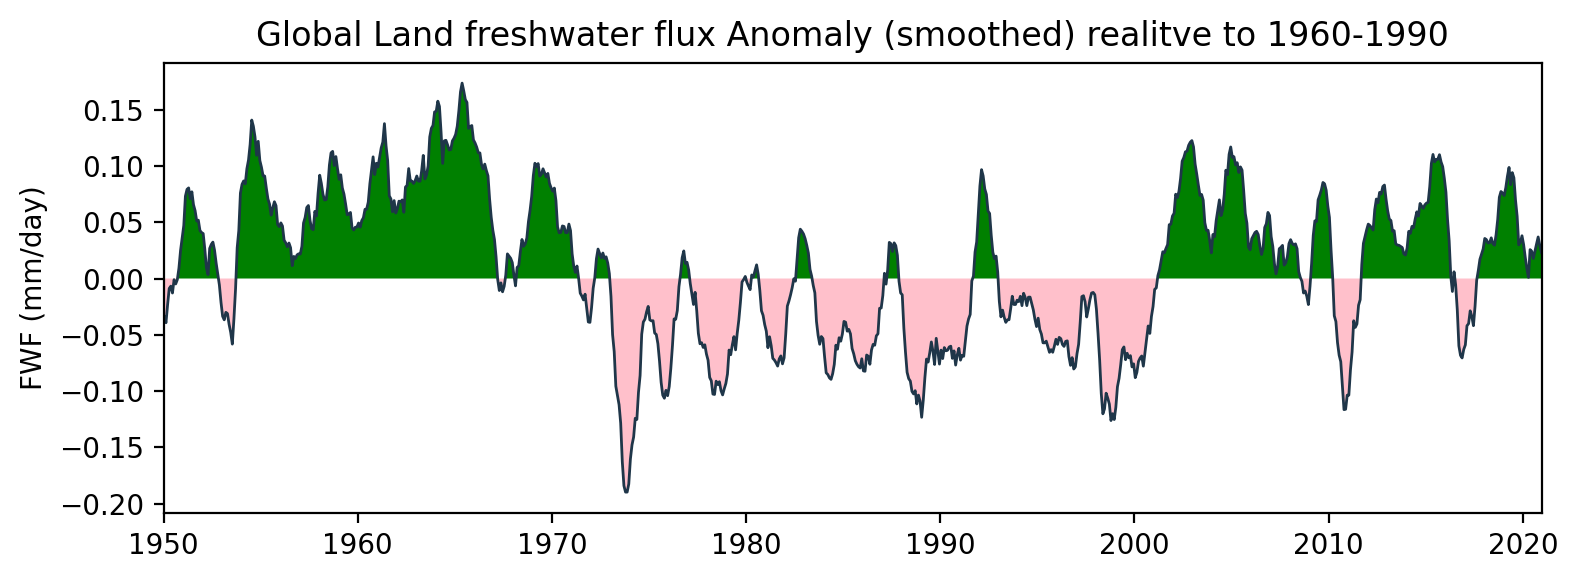

In [213]:
# QUICK TEST PLOT - smoothed anomaly timeseries 
#==============================================
plt.figure(figsize=(8,3),dpi=200)
plt.fill_between(sv_data['time'], sv_anom_smoothed , where=sv_anom_smoothed >= 0, facecolor="green",interpolate=True)
plt.fill_between(sv_data['time'], sv_anom_smoothed , where=sv_anom_smoothed  < 0, facecolor="pink",interpolate=True)
plt.plot(sv_data['time'], sv_anom_smoothed ,color='#1F3649',lw=1)
plt.xlim(int(sv_data['time'][0]), int(sv_data['time'][-1])+1)
plt.ylabel(f"{shortname} ({units})")
plt.title(f"{surface} {longname} Anomaly (smoothed) realitve to 1960-1990")
plt.tight_layout()

***
# Repeat for regional processing
***

In [214]:
# select region

#region = "Tropics"
#region = "North Atlantic"
#region = "Mediterian"
#region = "Australia"
region = "Amazon"



if region == "Tropics":
    xmin, xmax, ymin, ymax = 0,360,-30,30

elif region == "North Atlantic":
    xmin, xmax, ymin, ymax = 300,360,0,70

elif region == "Mediterian":
    xmin, xmax, ymin, ymax = 0,40,25,45

elif region == "Australia":
    xmin, xmax, ymin, ymax = 110,160,-45,-10

elif region == "Amazon":
    xmin, xmax, ymin, ymax = 270,330,-20,10


# define regional marker
if surface == "Global":
    mkr_reg = np.where((x2d >= xmin)&(x2d <= xmax)&(y2d >= ymin)&(y2d <= ymax)&(lsm_data['lsm'] >=0))
elif surface == "Global Land":
    mkr_reg = np.where((x2d >= xmin)&(x2d <= xmax)&(y2d >= ymin)&(y2d <= ymax)&(lsm_data['lsm'] > 0.3))
elif surface == "Global Ocean":
    mkr_reg = np.where((x2d >= xmin)&(x2d <= xmax)&(y2d >= ymin)&(y2d <= ymax)&(lsm_data['lsm'] < 0.3))


In [215]:
# calculate weighted mean time series of skin temperature and study variable
Ts_reg_timeseries = np.full(tdim, np.nan)
sv_reg_timeseries = np.full(tdim, np.nan)
for tt in range(tdim):
    # select data for region of interest
    roi_Ts = Ts_glb[tt,:,:][mkr_reg]
    roi_sv = sv_glb[tt,:,:][mkr_reg]
    
    # create a varialbe to scale the weights eithe by 1 or NaN. This is a simple way to
    # ensure the sum of the weights is masked according to the surface type
    scale = np.full(roi_sv.shape, 1.0)
    scale[roi_sv == np.nan] = np.nan
    Ts_reg_timeseries[tt] = np.nansum(roi_Ts*wgts[mkr_reg])/np.nansum(scale*wgts[mkr_reg])
    sv_reg_timeseries[tt] = np.nansum(roi_sv*wgts[mkr_reg])/np.nansum(scale*wgts[mkr_reg])

In [216]:
# calculate anomalies
# NOTE; we need to establish a common baseline period for the analysis. We will use 1960-1990
ref_period = np.where((ts_data['time'] >= 1960)&(ts_data['time'] < 1990))
Ts_reg_anom = np.full(tdim, np.nan)
sv_reg_anom = np.full(tdim, np.nan)
for mth in range(12):
    Ts_reg_anom[mth::12] = Ts_reg_timeseries[mth::12] - np.mean(Ts_reg_timeseries[ref_period][mth::12])
    sv_reg_anom[mth::12] = sv_reg_timeseries[mth::12] - np.mean(sv_reg_timeseries[ref_period][mth::12])

In [217]:
# smooth the time series with running average of 12 months
smth_win = 12
Ts_reg_anom_smoothed = simple_moving_average(Ts_reg_anom, smth_win)
sv_reg_anom_smoothed = simple_moving_average(sv_reg_anom, smth_win)

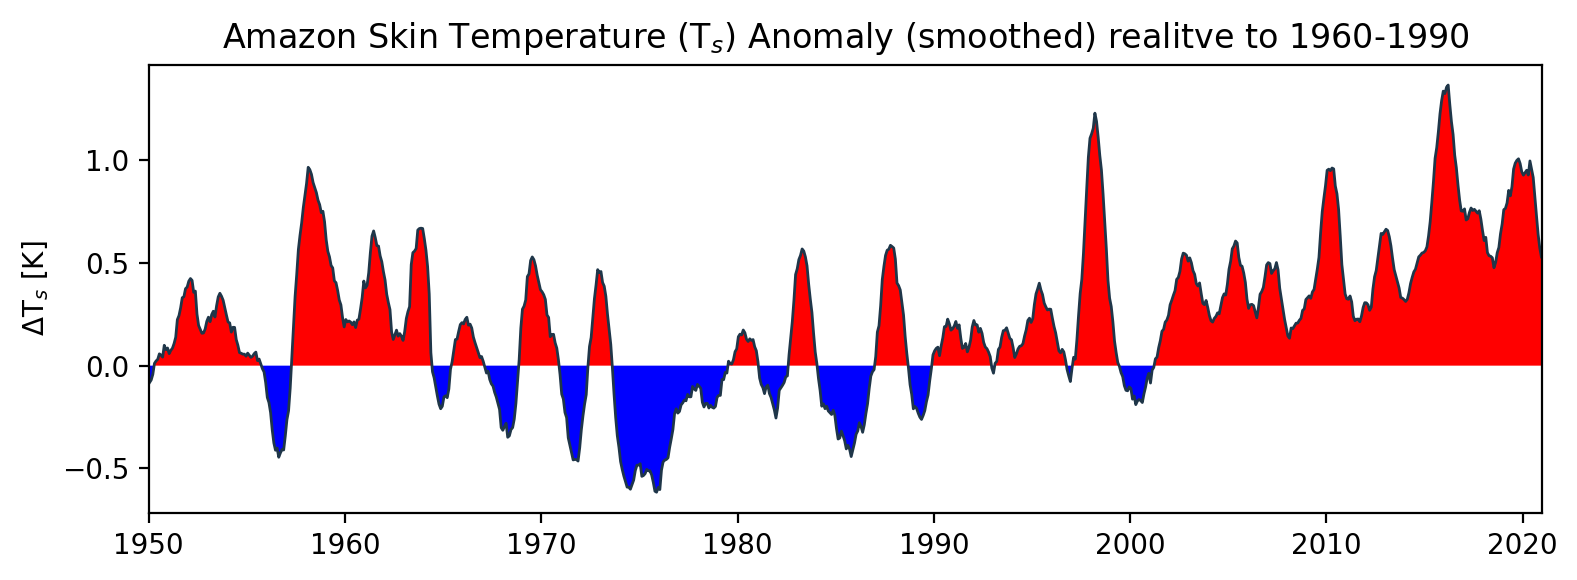

In [218]:
# QUICK TEST PLOT - smoothed anomaly timeseries 
#==============================================
plt.figure(figsize=(8,3),dpi=200)
plt.fill_between(ts_data['time'], Ts_reg_anom_smoothed , where=Ts_reg_anom_smoothed >= 0, facecolor="red",interpolate=True)
plt.fill_between(ts_data['time'], Ts_reg_anom_smoothed , where=Ts_reg_anom_smoothed  < 0, facecolor="blue",interpolate=True)
plt.plot(ts_data['time'], Ts_reg_anom_smoothed ,color='#1F3649',lw=1)
plt.xlim(int(ts_data['time'][0]), int(ts_data['time'][-1])+1)
plt.ylabel(r"$\Delta$T$_{s}$ [K]")
plt.title(f"{region} "+r'Skin Temperature (T$_{s}$) Anomaly (smoothed) realitve to 1960-1990')
plt.tight_layout()

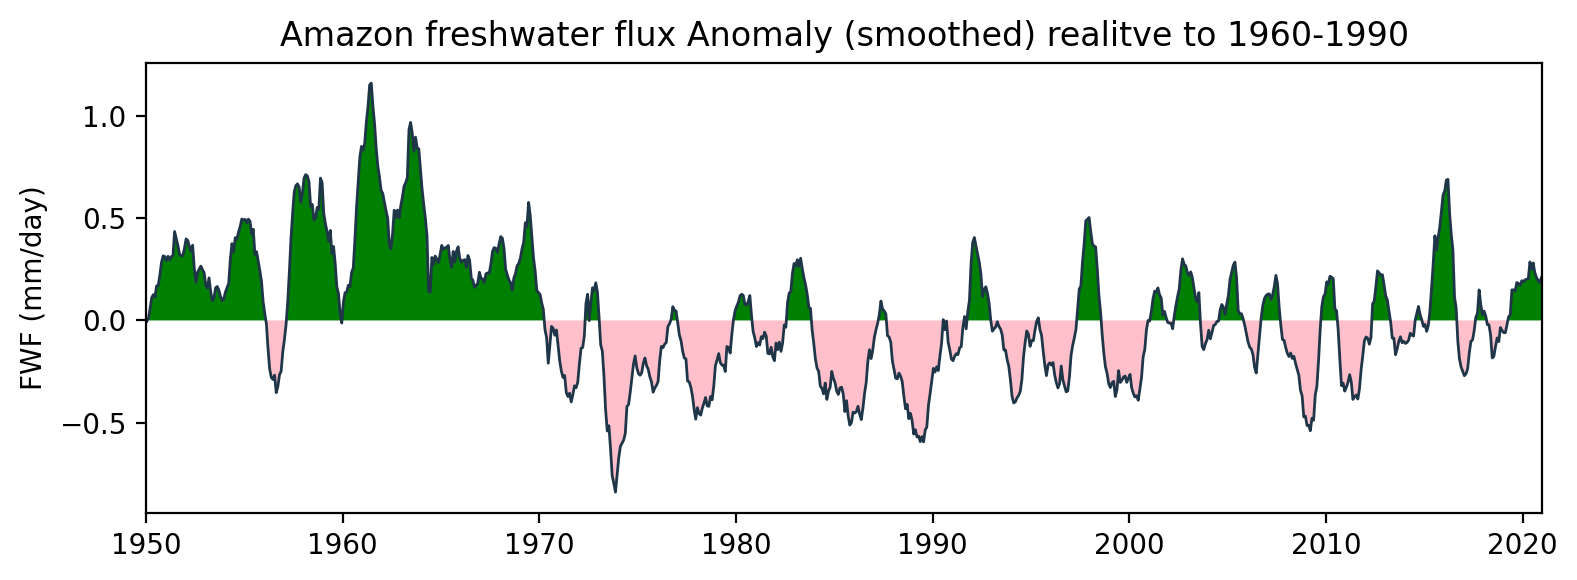

In [219]:
# QUICK TEST PLOT - smoothed anomaly timeseries 
#==============================================
plt.figure(figsize=(8,3),dpi=200)
plt.fill_between(sv_data['time'], sv_reg_anom_smoothed , where=sv_reg_anom_smoothed >= 0, facecolor="green",interpolate=True)
plt.fill_between(sv_data['time'], sv_reg_anom_smoothed , where=sv_reg_anom_smoothed  < 0, facecolor="pink",interpolate=True)
plt.plot(sv_data['time'], sv_reg_anom_smoothed ,color='#1F3649',lw=1)
plt.xlim(int(sv_data['time'][0]), int(sv_data['time'][-1])+1)
plt.ylabel(f"{shortname} ({units})")
plt.title(f"{region} {longname} Anomaly (smoothed) realitve to 1960-1990")
plt.tight_layout()

***
# Lets save the time series so we can reload them from here or in another notebook, or in an excell spreadsheet
***

In [220]:
# first write everything to a dictionary
#========================================
# format heading names
bits = surface.split(" ")
bits.append("Ts")
skt_name = "_".join(bits)

bits = surface.split(" ")
bits.append(shortname)
sv_name = "_".join(bits)

bits = region.split(" ")
bits.append("Ts")
skt_reg_name = "_".join(bits)

bits = region.split(" ")
bits.append(shortname)
sv_reg_name = "_".join(bits)

########################################
# write the data to a dictionary
results = {'frac_year': sv_data['time'],
           f'{skt_name}': Ts_anom_smoothed,
           f'{sv_name}': sv_anom_smoothed,
           f'{skt_reg_name}': Ts_reg_anom_smoothed,
           f'{sv_reg_name}': sv_reg_anom_smoothed,
          }

In [221]:
##################################################################################################
# SAVE THE DATA TO A .csv FILE

with open("coursework_era5_datasets_preprocessing.csv", "w") as fobj:
    # first we write a header, the \n tells the computer to start a new line
    header = ",".join(list(results.keys()))+"\n"
    fobj.write(f"{header}")
    # here we use zip in order to interate over all arrays at the same time
    for tstep in range(tdim):
        # we create a single string and write it to file
        line = []
        for v in results.keys():
            line.append(str(results[v][tstep]))
        line = ",".join(line)+"\n"     
        fobj.write(f"{line}")

***
# You can coninue with analysis under here, or work in another note book. Here we can see afew examples of analysis
***

In [222]:
# Lets read in some climate indices for later
clim_inds = read_csv("../CW5/data/climate_indicies.csv")

In [223]:
# First lets calculate some trends
#=================================
# set up an array to hold our results
Ts_trend = np.full((ydim,xdim),np.nan)
sv_trend = np.full((ydim,xdim),np.nan)

Ts_sig_corr = np.full((ydim,xdim),np.nan)
sv_sig_corr = np.full((ydim,xdim),np.nan)

# calculate Tskin and study variable anomalies relative to 1960-1990
Ts_anom_glb = np.full((tdim, ydim,xdim),np.nan)
sv_anom_glb = np.full((tdim, ydim,xdim),np.nan)
for mth in range(12):
    Ts_anom_glb[mth::12,:,:] = Ts_glb[mth::12,:,:] - np.nanmean(Ts_glb[ref_period[0],:,:][mth::12,:,:],axis=0)
    sv_anom_glb[mth::12,:,:] = sv_glb[mth::12,:,:] - np.nanmean(sv_glb[ref_period[0],:,:][mth::12,:,:],axis=0)

# now we loop over the y and x dimensions and calculate the linear fit between the skin temperature and time
for j in range(ydim):
    for i in range(xdim):
        # calculate correlation for grid cell (j,i)
        Ts_res = linregress(ts_data['time'],Ts_anom_glb[:,j,i])
        sv_res = linregress(ts_data['time'],sv_anom_glb[:,j,i])
        # write slope result to array, scale fromper month to per decade
        Ts_trend[j,i] = Ts_res.slope*120
        sv_trend[j,i] = sv_res.slope*120
        
        # if significant mark the poitionin the sig_corr array with a 1
        if Ts_res.pvalue < 0.01:
            Ts_sig_corr[j,i] = 1
        else:
            pass
        if sv_res.pvalue < 0.01:
            sv_sig_corr[j,i] = 1
        else:
            pass
            

C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_14992\3822601348.py:14: RuntimeWarning: Mean of empty slice
  Ts_anom_glb[mth::12,:,:] = Ts_glb[mth::12,:,:] - np.nanmean(Ts_glb[ref_period[0],:,:][mth::12,:,:],axis=0)
C:\Users\tjt11.UOL\AppData\Local\Temp\ipykernel_14992\3822601348.py:15: RuntimeWarning: Mean of empty slice
  sv_anom_glb[mth::12,:,:] = sv_glb[mth::12,:,:] - np.nanmean(sv_glb[ref_period[0],:,:][mth::12,:,:],axis=0)


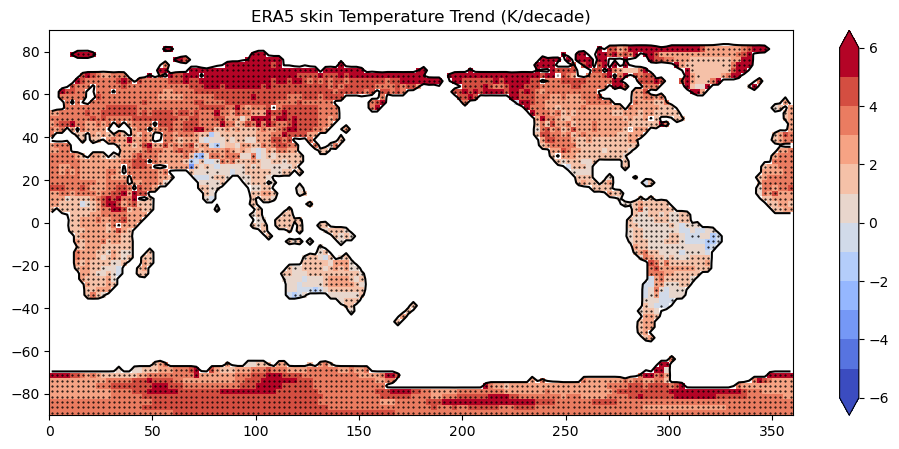

In [224]:
# mask the sig_corr array
Ts_sig_corr = np.ma.masked_invalid(Ts_sig_corr)
# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=Ts_sig_corr.mask).compressed()
sig_y2d = np.ma.masked_array(y2d,mask=Ts_sig_corr.mask).compressed()

# plot the same figure from before
plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], Ts_trend, vmin=-6, vmax=6, cmap=plt.get_cmap('coolwarm', 12))
plt.colorbar(extend='both')
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title("ERA5 skin Temperature Trend (K/decade)")
# now add the stippling to indicate areas of statisitical significance of the trends
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

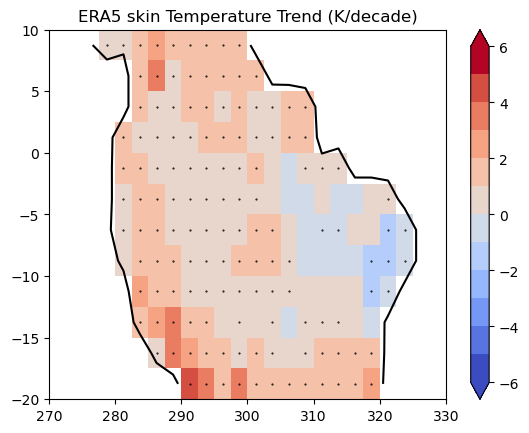

In [225]:
# DO THE SAME PLOT BUT FOR THE REGION
# plot the same figure from before
plt.figure()#figsize=(12,5))
xmkr = np.where((ts_data['longitude'] >= xmin)&(ts_data['longitude'] <= xmax)) 
ymkr = np.where((ts_data['latitude'] >= ymin)&(ts_data['latitude'] <= ymax))

# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=Ts_sig_corr.mask)[ymkr[0],:][:,xmkr[0]].compressed()
sig_y2d = np.ma.masked_array(y2d,mask=Ts_sig_corr.mask)[ymkr[0],:][:,xmkr[0]].compressed()

plt.pcolormesh(ts_data['longitude'][xmkr], ts_data['latitude'][ymkr], 
               Ts_trend[ymkr[0],:][:,xmkr[0]], vmin=-6, vmax=6, 
               cmap=plt.get_cmap('coolwarm', 12))

plt.colorbar(extend='both')
plt.contour(ts_data['longitude'][xmkr], ts_data['latitude'][ymkr],
            lsm_data['lsm'][ymkr[0],:][:,xmkr[0]],levels=[0.3],cmap='Greys_r')
plt.title("ERA5 skin Temperature Trend (K/decade)")
# now add the stippling to indicate areas of statisitical significance of the trends
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

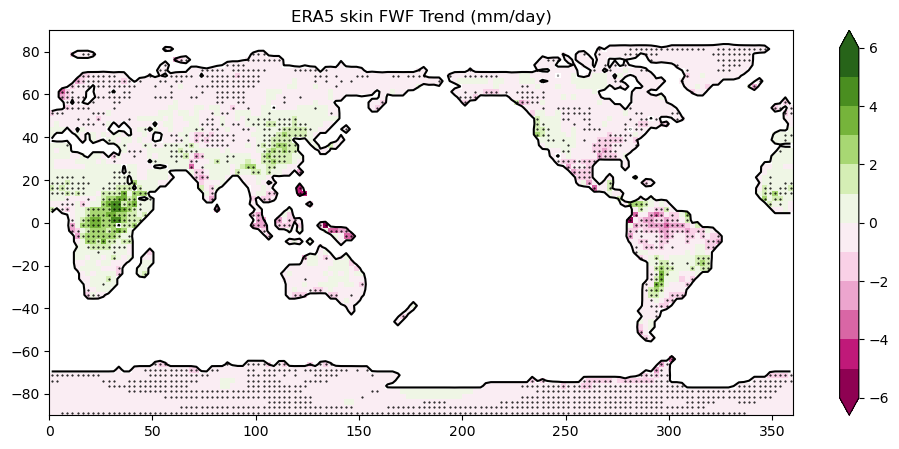

In [226]:
# mask the sig_corr array
sv_sig_corr = np.ma.masked_invalid(sv_sig_corr)
# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=sv_sig_corr.mask).compressed()
sig_y2d = np.ma.masked_array(y2d,mask=sv_sig_corr.mask).compressed()

# plot the same figure from before
plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], sv_trend, vmin=-6, vmax=6, cmap=plt.get_cmap('PiYG', 12))
plt.colorbar(extend='both')
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title(f"ERA5 skin {shortname} Trend ({units})")
# now add the stippling to indicate areas of statisitical significance of the trends
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

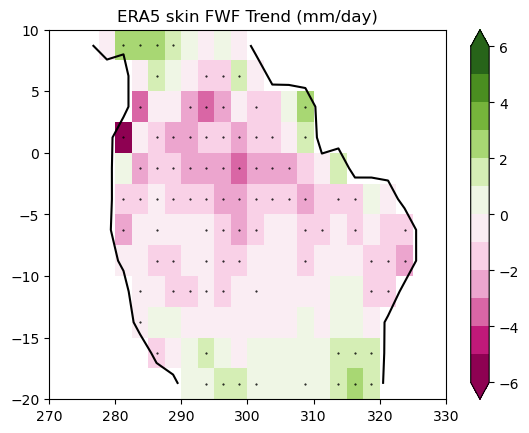

In [227]:
# DO THE SAME PLOT BUT FOR THE REGION
# plot the same figure from before
plt.figure()#figsize=(12,5))
xmkr = np.where((ts_data['longitude'] >= xmin)&(ts_data['longitude'] <= xmax)) 
ymkr = np.where((ts_data['latitude'] >= ymin)&(ts_data['latitude'] <= ymax))

# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=sv_sig_corr.mask)[ymkr[0],:][:,xmkr[0]].compressed()
sig_y2d = np.ma.masked_array(y2d,mask=sv_sig_corr.mask)[ymkr[0],:][:,xmkr[0]].compressed()

plt.pcolormesh(ts_data['longitude'][xmkr], ts_data['latitude'][ymkr], 
               sv_trend[ymkr[0],:][:,xmkr[0]], vmin=-6, vmax=6, 
               cmap=plt.get_cmap('PiYG', 12))

plt.colorbar(extend='both')
plt.contour(ts_data['longitude'][xmkr], ts_data['latitude'][ymkr],
            lsm_data['lsm'][ymkr[0],:][:,xmkr[0]],levels=[0.3],cmap='Greys_r')
plt.title(f"ERA5 skin {shortname} Trend ({units})")
# now add the stippling to indicate areas of statisitical significance of the trends
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

***
# lets look at correlation to climate indices
*** 

In [228]:
# pick a climate index
#======================
#clim_ind = clim_inds['qbo']
#ciname="QBO"

#clim_ind = clim_inds['pdo']
#ciname="PDO"

#clim_ind = clim_inds['nao']
#ciname="NAO"

clim_ind = clim_inds['enso3.4']
ciname="Nino3.4"

In [229]:
# set up an array to hold our results
Ts_corr_to_clim_ind = np.full((ydim,xdim),np.nan)
sv_corr_to_clim_ind = np.full((ydim,xdim),np.nan)
Ts_sig_corr = np.full((ydim,xdim),np.nan)
sv_sig_corr = np.full((ydim,xdim),np.nan)

# now we loop over the y and x dimensions and calculate the correlation between the skin temperature (skt) ans the ENSO SST anomolies
for j in range(ydim):
    for i in range(xdim):
        # calculate correlation for grid cell (j,i)
        Ts_res = pearsonr(Ts_glb[:,j,i], clim_ind)
        sv_res = pearsonr(sv_glb[:,j,i], clim_ind)
        # write correlation result to array
        Ts_corr_to_clim_ind [j,i] = Ts_res.statistic
        sv_corr_to_clim_ind [j,i] = Ts_res.statistic
        
        # if significant mark the poitionin the sig_corr array with a 1
        if Ts_res.pvalue < 0.01:
            Ts_sig_corr[j,i] = 1
        else:
            pass
        if sv_res.pvalue < 0.01:
            sv_sig_corr[j,i] = 1
        else:
            pass

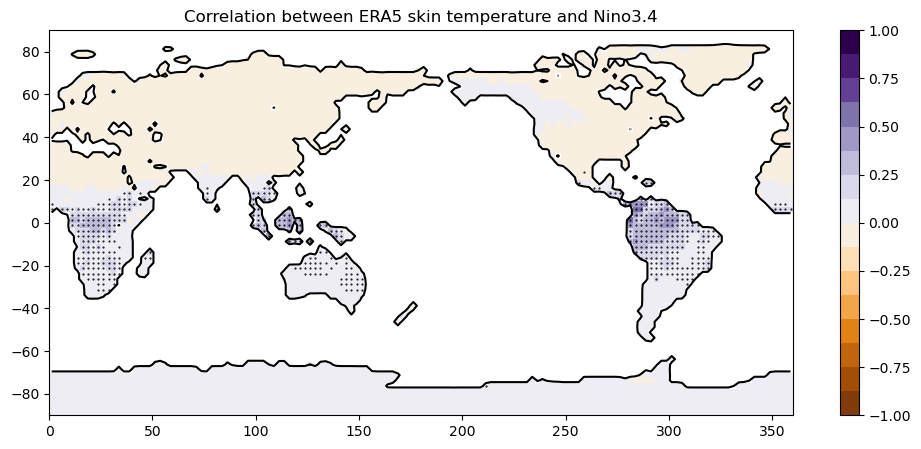

In [230]:
Ts_sig_corr = np.ma.masked_invalid(Ts_sig_corr)
# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=Ts_sig_corr.mask).compressed()
sig_y2d = np.ma.masked_array(y2d,mask=Ts_sig_corr.mask).compressed()

# plot the same figure from before
plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], Ts_corr_to_clim_ind, vmin=-1, vmax=1,cmap=plt.get_cmap('PuOr', 16))
plt.colorbar()
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title(f"Correlation between ERA5 skin temperature and {ciname}")
# now add the stippling to indicate areas of statisitical significance in the correlations
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

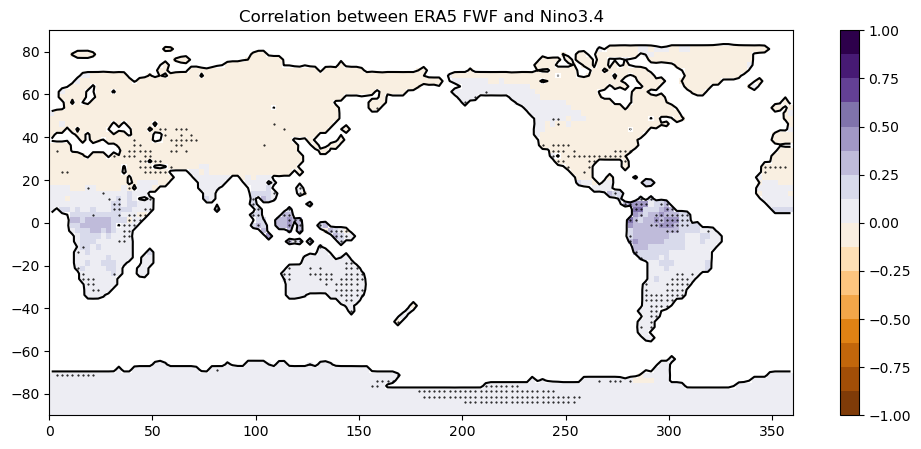

In [231]:
sv_sig_corr = np.ma.masked_invalid(sv_sig_corr)
# apply the mask to the 2D lons and lats, then compress
sig_x2d = np.ma.masked_array(x2d,mask=sv_sig_corr.mask).compressed()
sig_y2d = np.ma.masked_array(y2d,mask=sv_sig_corr.mask).compressed()

# plot the same figure from before
plt.figure(figsize=(12,5))
plt.pcolormesh(ts_data['longitude'], ts_data['latitude'], sv_corr_to_clim_ind, vmin=-1, vmax=1,cmap=plt.get_cmap('PuOr', 16))
plt.colorbar()
plt.contour(ts_data['longitude'], ts_data['latitude'],lsm_data['lsm'],levels=[0.3],cmap='Greys_r')
plt.title(f"Correlation between ERA5 {shortname} and {ciname}")
# now add the stippling to indicate areas of statisitical significance in the correlations
plt.plot(sig_x2d,sig_y2d,'.',ms=1,color='k')

***
# Lets make some other plot, scatter and PDFs
***

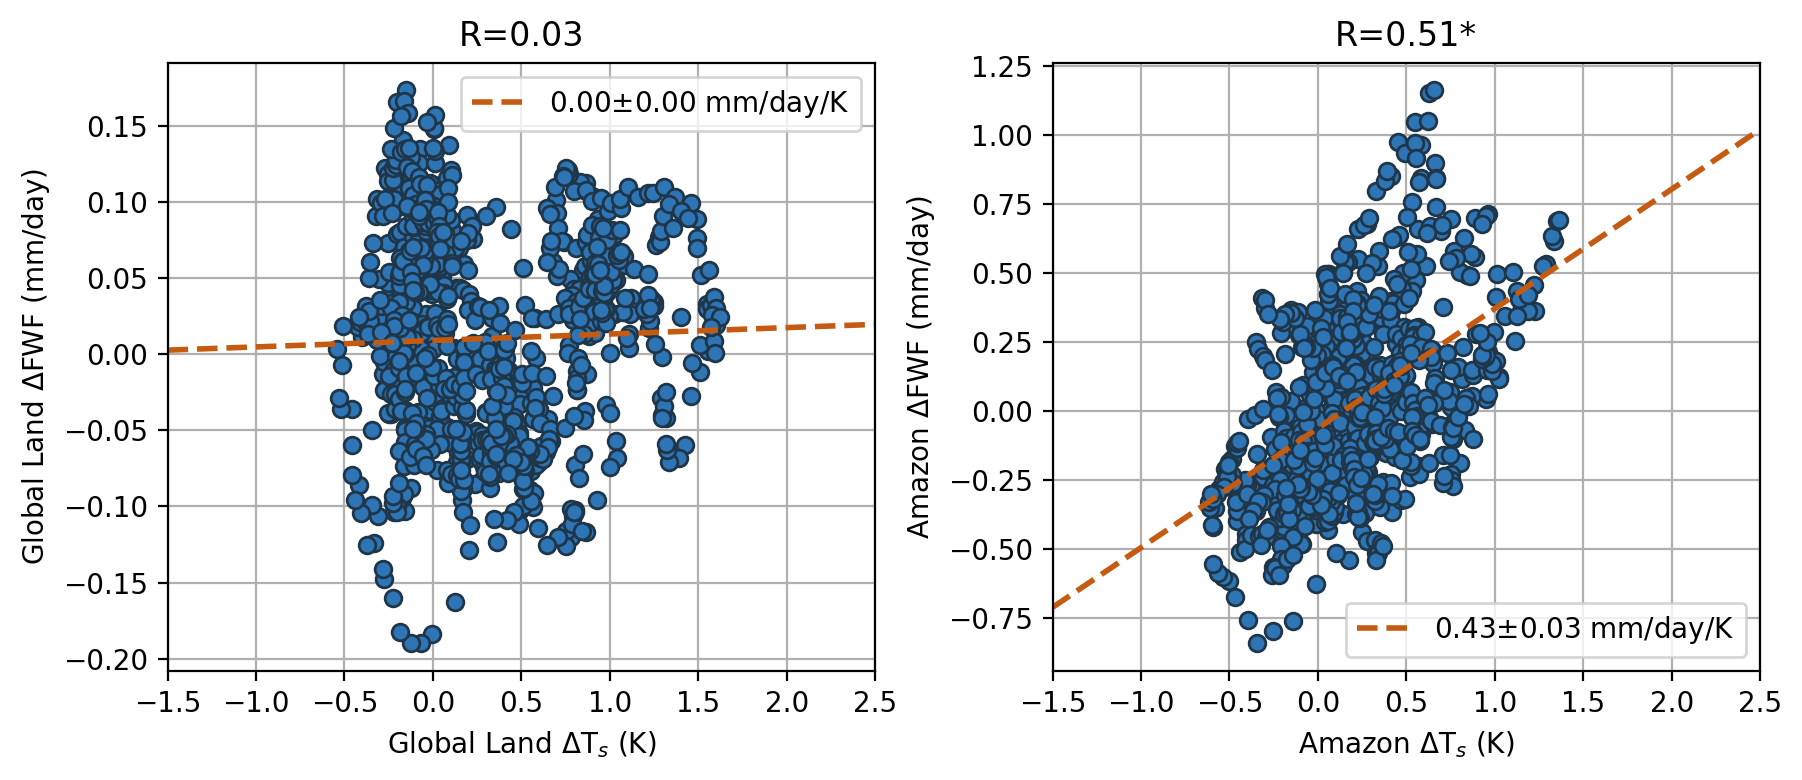

In [232]:
plt.figure(figsize=(9,4),dpi=200)
plt.subplot(121)
plot_studyVar_vs_Ts(Ts_anom_smoothed, sv_anom_smoothed, shortname, units, surface, surface)
plt.subplot(122)
plot_studyVar_vs_Ts(Ts_reg_anom_smoothed, sv_reg_anom_smoothed, shortname, units, region, region)
plt.tight_layout()

### Sometimes when we look at regressions in absolute units they can look uncorrelatated. Another was is to conver to relative units and see if we get a more robust answer

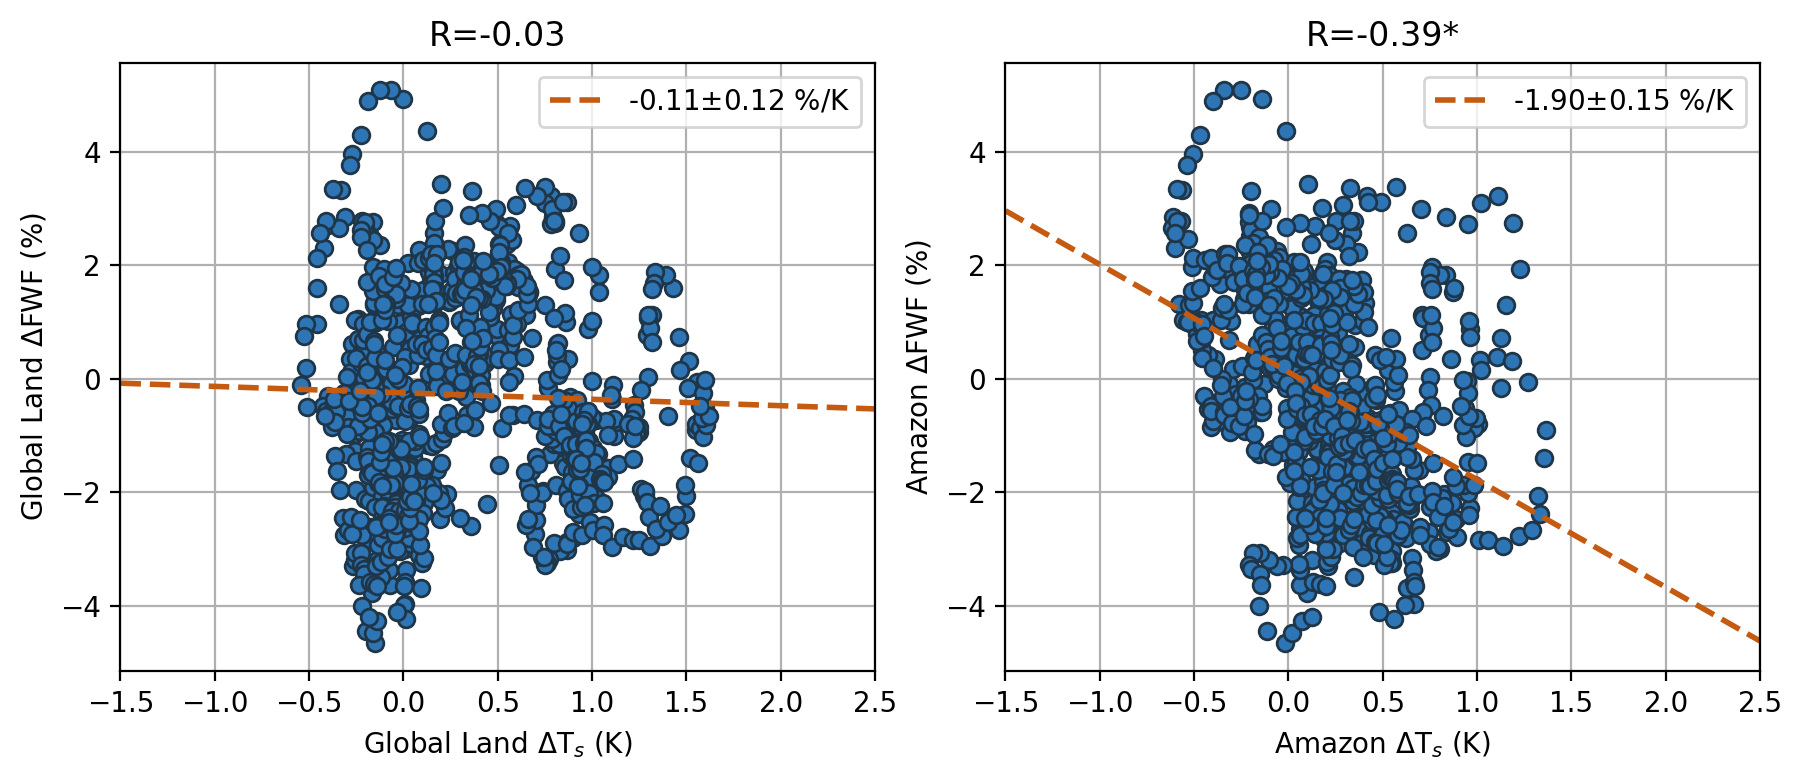

In [233]:
plt.figure(figsize=(9,4),dpi=200)
tmp = 100*(sv_anom_smoothed/sv_timeseries.mean())
plt.subplot(121)
plot_studyVar_vs_Ts(Ts_anom_smoothed, tmp, shortname, "%", surface, surface)
plt.subplot(122)
plot_studyVar_vs_Ts(Ts_reg_anom_smoothed, tmp, shortname, "%", region, region)
plt.tight_layout()

In [236]:
# create index values for pre and post 2001
##########################################################################
pre2000 = np.where(ts_data['time'] < 2001)
aft2000 = np.where(ts_data['time'] >= 2001)

# 4. Calculate PDFs
#########################################################################################################
# Tskin
maxval = int(np.ceil(np.max([Ts_anom_smoothed.max(), Ts_reg_anom_smoothed.max()])))+0.5
minval = int(np.floor(np.min([Ts_anom_smoothed.min(), Ts_reg_anom_smoothed.min()])))-0.5
pre_lst_pdf, xvals_lst = calculate_probDensFunc(Ts_anom_smoothed[pre2000], minval, maxval, nbins=80)
aft_lst_pdf, xvals_lst = calculate_probDensFunc(Ts_anom_smoothed[aft2000], minval, maxval, nbins=80)
pre_reg_lst_pdf, xvals_lst = calculate_probDensFunc(Ts_reg_anom_smoothed[pre2000], minval, maxval, nbins=80)
aft_reg_lst_pdf, xvals_lst = calculate_probDensFunc(Ts_reg_anom_smoothed[aft2000], minval, maxval, nbins=80)

# study variable
maxval = int(np.ceil(np.max([sv_anom_smoothed.max(), sv_reg_anom_smoothed.max()])))#+0.5
minval = int(np.floor(np.min([sv_anom_smoothed.min(), sv_reg_anom_smoothed.min()])))#-0.5
pre_sv_pdf, xvals_sv = calculate_probDensFunc(sv_anom_smoothed[pre2000], minval, maxval, nbins=80)
aft_sv_pdf, xvals_sv = calculate_probDensFunc(sv_anom_smoothed[aft2000], minval, maxval, nbins=80)
pre_reg_sv_pdf, xvals_sv = calculate_probDensFunc(sv_reg_anom_smoothed[pre2000], minval, maxval, nbins=80)
aft_reg_sv_pdf, xvals_sv = calculate_probDensFunc(sv_reg_anom_smoothed[aft2000], minval, maxval, nbins=80)

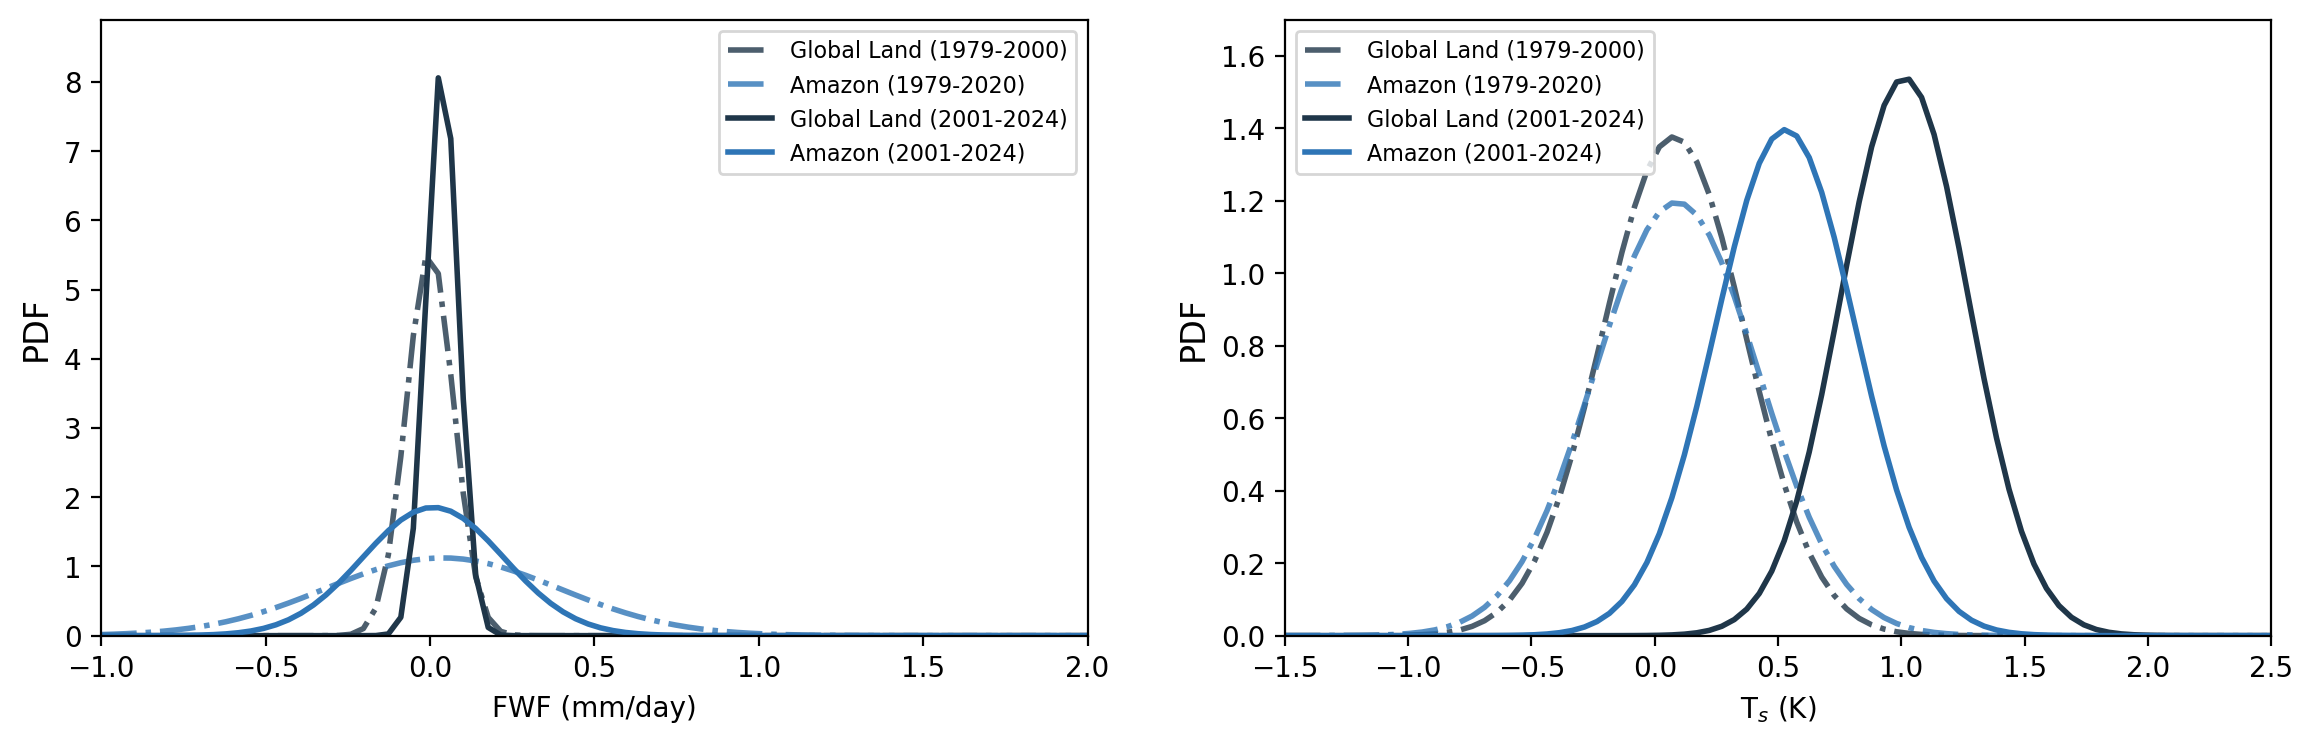

In [237]:
plt.figure(figsize=(14,4),dpi=200)
plt.subplot(121)
plot_pdfs(xvals_sv, pre_sv_pdf, aft_sv_pdf, pre_reg_sv_pdf, aft_reg_sv_pdf, surface, region, shortname, units)
plt.subplot(122)
plot_pdfs(xvals_lst, pre_lst_pdf, aft_lst_pdf, pre_reg_lst_pdf, aft_reg_lst_pdf, surface, region, r"T$_{s}$", "K")          

***
# Finally, lets make some time series plots with trends calculated
***

In [238]:
#LEST PLOT THE TIME SERIES FROM THE PYTHON DICTIONARY WE MADE EARLIER
#====================================================================
# PRINT VARIABLES TO SCREEN SO WE CAN SEE THEM
list(results.keys())[1:] # THIS ALLOWS US TO IGNORE 'frac_year' WHICH IS IN POSITION 0

['Global_Land_Ts', 'Global_Land_FWF', 'Amazon_Ts', 'Amazon_FWF']

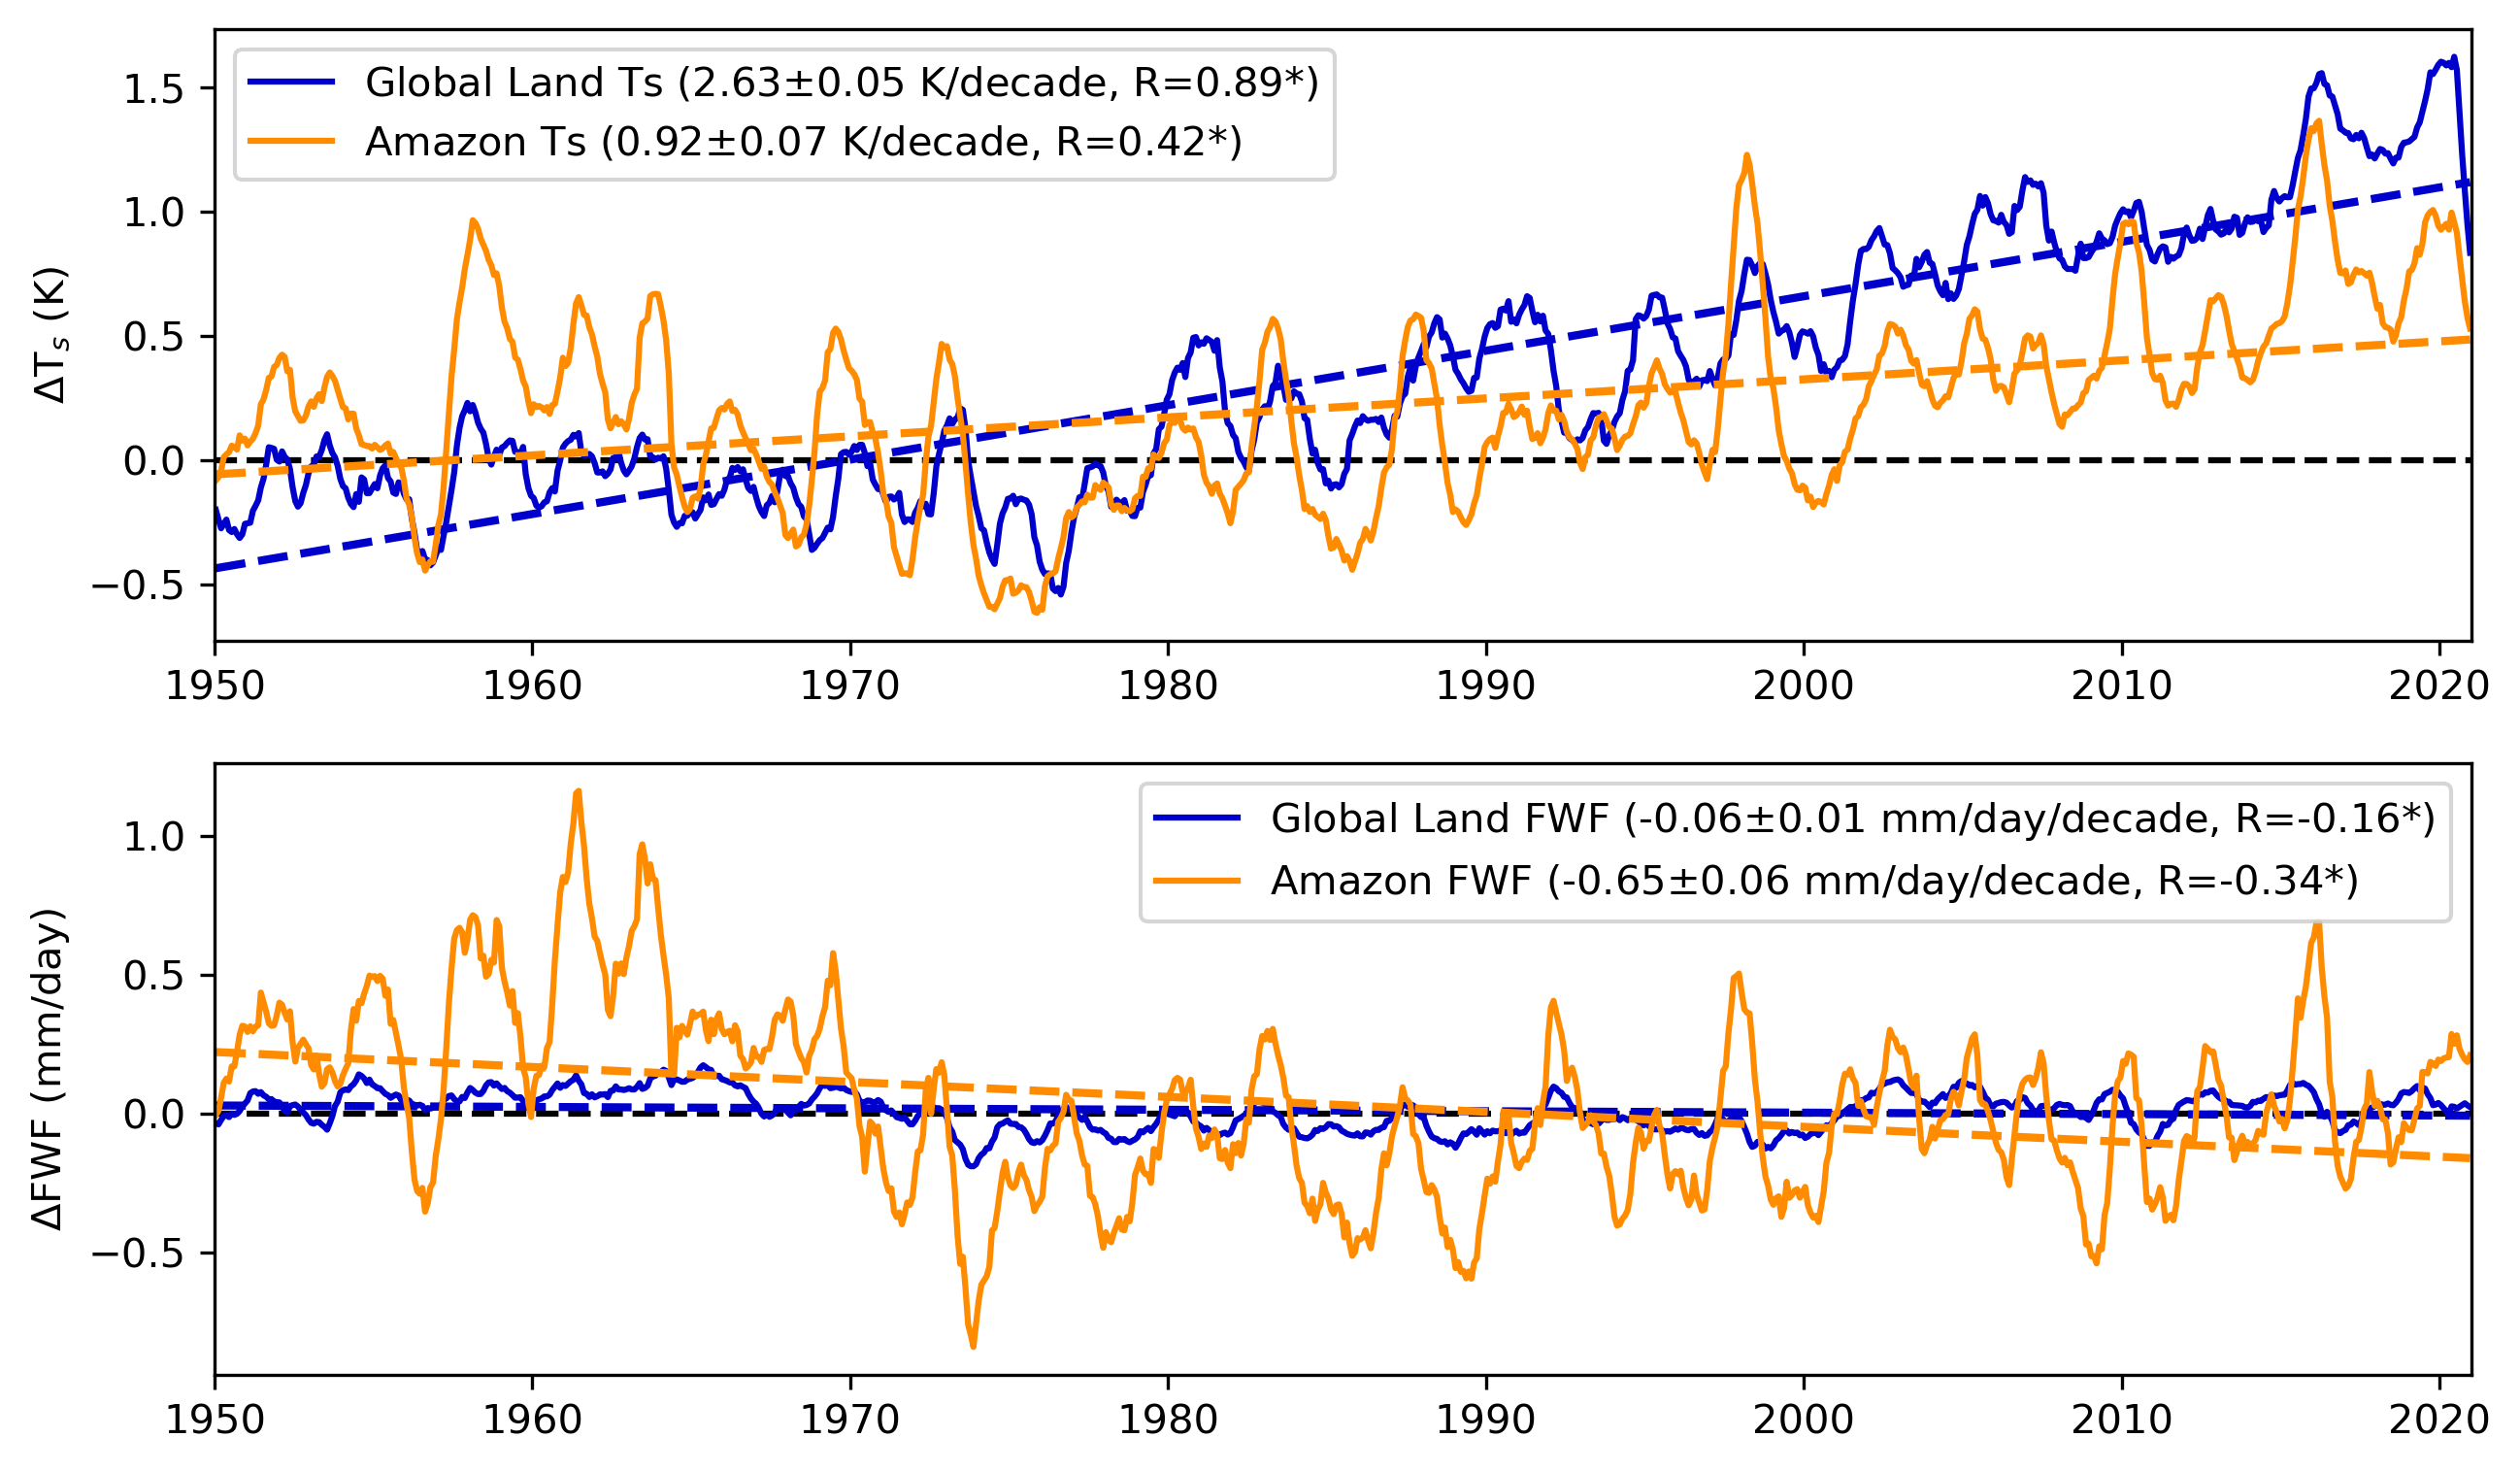

In [239]:
plt.figure(figsize=(10,6),dpi=300)
pcols = ['mediumblue', 'mediumblue','darkorange', 'darkorange']
# named colour can be found at https://matplotlib.org/stable/gallery/color/named_colors.html
punits= ["K", units, "K", units]
for ii, var in enumerate(list(results.keys())[1:]):
    pdx = (ii % 2)+1
    plt.subplot(2,1,pdx)
    if ii < 2:
        plt.plot([1950,2024], [0,0], "--k")
    else:
        pass
    # calculate the trend
    slope, intercept, r, p, se = linregress(results['frac_year'], results[var])
    # pearson coeeficients
    Rs = f"{r:0.2f}"
    if p < 0.01:
        Rs+="*"

    trend_lab = f" ({slope*120:0.2f}"+r"$\pm$"+f"{se*120:0.2f} {punits[ii]}/decade, R={Rs})"
    plt.plot(results['frac_year'], results[var],color=pcols[ii], label=f'{" ".join(var.split("_"))}'+trend_lab)
     # plot fit
    yg = intercept+slope*results['frac_year']
    plt.plot(results['frac_year'], yg,'--',color=pcols[ii],lw=2)
    if ii >= 2:
        plt.legend()
        if (ii % 2) == 1:
            plt.xlim(1950, 2021)
            plt.ylabel(r"$\Delta$"+f"{shortname} ({units})")
        else:
            plt.xlim(1950, 2021)
            plt.ylabel(r"$\Delta$T$_{s}$ (K)")